## Replication of results from paper: "Predicting yeast synthetic lethal genetic interactions using protein domains" 

- Authors: Bo Li, Feng Luo,School of Computing,Clemson University,Clemson, SC, USA
- e-mail: bol, luofeng@clemson.edu
- year:2009

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict 
import seaborn as sns
import matplotlib.cm as cm

In [2]:
## Datasets
data_domains=pd.read_excel(r'C:\Users\linigodelacruz\Documents\PhD_2018\Documentation\Calculations\machine-learning-for-yeast\datasets-for-learning\proteins-domains-from-Pfam.xlsx',header=0,index_col='Unnamed: 0')
data_domains=data_domains.dropna()
data_sl=pd.read_excel(r'C:\Users\linigodelacruz\Documents\PhD_2018\Documentation\Calculations\machine-learning-for-yeast\datasets-for-learning\data-synthetic-lethals.xlsx',header=0)
data_nonsl=pd.read_excel(r'C:\Users\linigodelacruz\Documents\PhD_2018\Documentation\Calculations\machine-learning-for-yeast\datasets-for-learning\data-positive-genetic.xlsx',header=0)



## Building the feature matrix
 One matrix for true SL where each column is one pair of SL. Every column will be a vector of  0,1 or 2 depending on the comparison with the domain list. for colum i the jth element = 0 if the jth element of the domain list is not in neither protein A and B, 1, if it is in one of them and 2 if it is in both of them .  




## Building the list of proteins domains id per protein pair separately :

1. List of protein A: Search for the Sl/nSL database the query gene name and look in the protein domain database which protein domains id has each of those queries.
2. List of protein B: Search for the Sl/nSL database the target gene name of the previous query and look in the protein domain database which protein domains id has each of those target genes.

In [3]:

# Selecting the meaningful columns in the respective dataset
domain_id_list=data_domains['domain-name']
query_gene=data_sl['gene-query-name']
target_gene=data_sl['gene-target-name']
query_gene_nonlethal=data_nonsl['gene-query-name']
target_gene_nonlethal=data_nonsl['gene-target-name']



# Initialising the arrays
protein_a_list=[]
protein_b_list=[]
protein_a_list_non=[]
protein_b_list_non=[]

# For loop for 500 pairs from the SL/nSl pair list , and creating a big array of proteind domains id per protein pair
for m in np.arange(0,5000):
    protein_a=data_domains[data_domains['name']==query_gene[m]]
    protein_b=data_domains[data_domains['name']==target_gene[m]]
    protein_a_list.append(protein_a['domain-name'].tolist())
    protein_b_list.append(protein_b['domain-name'].tolist())

    protein_a_non=data_domains[data_domains['name']==query_gene_nonlethal[m]]
    protein_b_non=data_domains[data_domains['name']==target_gene_nonlethal[m]]
    protein_a_list_non.append(protein_a_non['domain-name'].tolist())
    protein_b_list_non.append(protein_b_non['domain-name'].tolist())
    

```We have 17871 SL interactions out of 1727 proteins```

## removed protein pairs from study if either protein in the pair does not contain any domain

In [4]:
def remove_empty_domains(protein_list_search,protein_list_pair):
    index=[]
    for i in np.arange(0,len(protein_list_search)):
        if protein_list_search[i]==[]:
            index.append(i) ## index of empty values for the protein_a_list meaning they dont have any annotated domain

    y=[x for x in np.arange(0,len(protein_list_search)) if x not in index] # a list with non empty values from protein_a list

    protein_list_search_new=[]
    protein_list_pair_new=[]
    for i in y:
        protein_list_search_new.append(protein_list_search[i])
        protein_list_pair_new.append(protein_list_pair[i])
    return protein_list_search_new,protein_list_pair_new

## evaluating the function

protein_a_list_new,protein_b_list_new=remove_empty_domains(protein_a_list,protein_b_list)
protein_a_list_non_new,protein_b_list_non_new=remove_empty_domains(protein_a_list_non,protein_b_list_non)

## Select from each ordered indexes of  domain id list which of them appear once, in both or in any of the domains of each protein pair

In [5]:
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y] # a function that give the index of whether a value appear in array or not
a=[1,2,2,4,5,6,7,8,9,10]
get_indexes(2,a)

[1, 2]

In [56]:
def feature_building(protein_a_list_new,protein_b_list_new):
    x = np.unique(domain_id_list)
    protein_feat_true=np.zeros(shape=(len(x),len(protein_a_list_new)))
    pair_a_b_array=[]
    for i in np.arange(0,len(protein_a_list_new)):
        index_a=[]
        pair=[protein_a_list_new[i],protein_b_list_new[i]]
        pair_a_b=np.concatenate(pair).ravel()
        pair_a_b_array.append(pair_a_b)

    for i in np.arange(0,len(pair_a_b_array)):  
        array,index,counts=np.unique(pair_a_b_array[i],return_index=True,return_counts=True)
        for k,m in zip(counts,array):
            if k ==2:
                protein_feat_true[get_indexes(m,x),i]=2
                
            if k==1:
                protein_feat_true[get_indexes(m,x),i]=1
            # print(index_a[m],i)
    return protein_feat_true

In [58]:
protein_feat_true=feature_building(protein_b_list_new=protein_b_list_new,protein_a_list_new=protein_a_list_new)
protein_feat_true_pd=pd.DataFrame(protein_feat_true.T)

protein_feat_non_true=feature_building(protein_b_list_new=protein_b_list_non_new,protein_a_list_new=protein_a_list_non_new)

protein_feat_non_true_pd=pd.DataFrame(protein_feat_non_true.T)
# stats_lethals=protein_feat_true_pd.describe()
# stats_lethals.index

In [59]:
index_2_true=np.where(protein_feat_true_pd==2)
index_2_nontrue=np.where(protein_feat_non_true_pd==2)
index_1_true=np.where(protein_feat_true_pd==1)
print('the number of twos in the SL array is',len(index_2_true[0]))
print('the number of ones in the SL array is',len(index_1_true[0]))
print('the number of twos in the PI array is',len(index_2_nontrue[0]))

the number of twos in the SL array is 926
the number of ones in the SL array is 12334
the number of twos in the PI array is 471


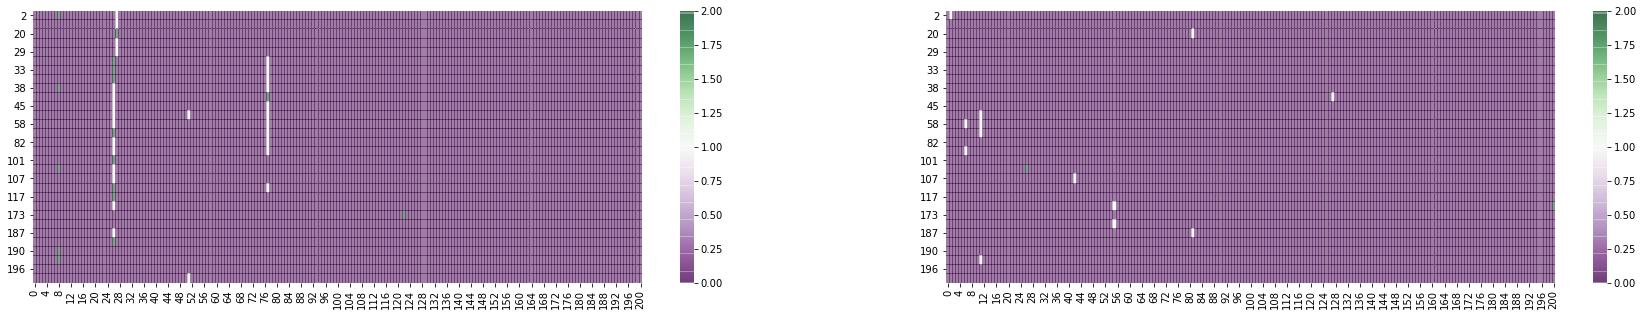

In [62]:
fig, axs = plt.subplots(ncols=2, figsize=(30,5))
sns.heatmap(protein_feat_true_pd.iloc[index_2_true[0][0:30],0:201],cmap=cm.PRGn,alpha=0.5,vmax=2,vmin=0,ax=axs[0])
sns.heatmap(protein_feat_non_true_pd.iloc[index_2_true[0][0:30],0:201],cmap=cm.PRGn,alpha=0.5,vmax=2,vmin=0,ax=axs[1])

In [63]:
protein_feat_true_pd['lethality']=np.ones(shape=(len(protein_a_list_new)))
protein_feat_non_true_pd['lethality']=np.zeros(shape=(len(protein_a_list_non_new)))

In [64]:
feature_post=pd.concat([protein_feat_true_pd,protein_feat_non_true_pd],axis=0)

In [65]:
feature_post=feature_post.set_index(np.arange(0,len(protein_a_list_new)+len(protein_a_list_non_new)))

In [66]:
feature_post.to_excel('feature-matrix-positive-vs-SL-domains.xlsx')

In [70]:
#feature_post=pd.read_excel('feature-matrix.xlsx',index_col='Unnamed: 0')
np.shape(feature_post)

(9252, 3026)

In [81]:
mean=feature_post.T.describe().loc['mean']
std=feature_post.T.describe().loc['std']
lethality=feature_post['lethality']

In [87]:
corr_keys=pd.concat([mean,std,lethality],axis=1)

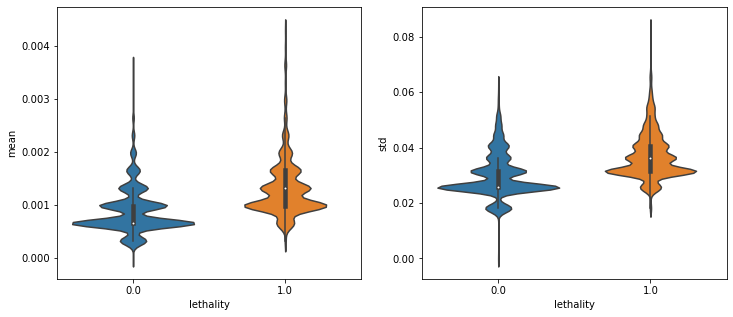

In [175]:
fig, axs = plt.subplots(ncols=2, figsize=(12,5))
sns.violinplot(x="lethality", y="mean", data=corr_keys,ax=axs[0])
sns.violinplot(x="lethality", y="std", data=corr_keys,ax=axs[1])

In [89]:
corr_keys.corr()

mean       std  lethality
mean       1.000000  0.927670   0.409402
std        0.927670  1.000000   0.408173
lethality  0.409402  0.408173   1.000000

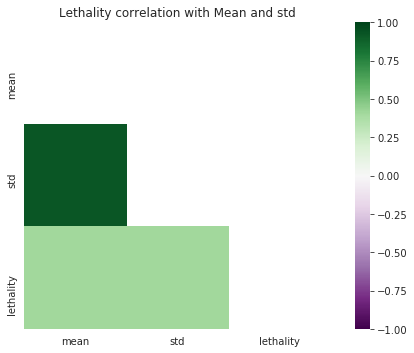

In [91]:
corr = corr_keys.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
import matplotlib.cm as cm
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, vmax=1,vmin=-1 ,square=True,cmap=cm.PRGn)
ax.set_title('Lethality correlation with Mean and std')
plt.tight_layout()
plt.savefig('output-images/corr-heatmap-mean-std-lethality-using-feature-as-paper.png',dpi=300,transparent=True,format='png')

In [ ]:
# data_all.to_excel('feature-matrix-all.xlsx')

In [ ]:
############## Read the data ############################

# data_all=pd.read_excel('feature-matrix-all.xlsx')

In [93]:
X, y = feature_post.drop(columns=["lethality"]), feature_post["lethality"]


In [94]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test =  train_test_split(X,y,test_size = 0.3, random_state= 0)

In [108]:
from sklearn import svm

clf = svm.SVC(kernel='linear', C=1).fit(X_train, y_train)
clf.score(X_test, y_test)

0.8721181556195965

In [99]:
from sklearn import metrics

y_pred = clf.predict(X_test)


the r-squared is: 0.4883321261776259


In [102]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
n_samples = X.shape[0]
cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
cross_val_score(clf, X, y, cv=cv)

array([0.87211816, 0.85878963, 0.8537464 , 0.85482709, 0.85266571])

Text(0, 0.5, 'Predicted')

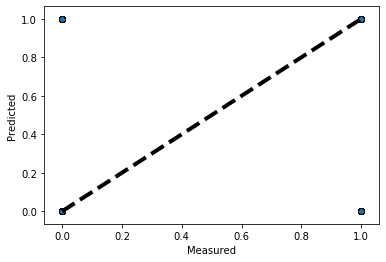

In [112]:
# cross_val_predict returns an array of the same size as `y` where each entry
# is a prediction obtained by cross validation:
from sklearn.model_selection import cross_val_predict
predicted = cross_val_predict(clf, X, y, cv=5)

fig, ax = plt.subplots()
ax.scatter(y, predicted, edgecolors=(0, 0, 0))
ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')

In [ ]:
import sklearn.metrics as metrics
scores=clf.fit(X_train, y_train).decision_function(X_test)

fpr, tpr, thresholds = metrics.roc_curve(y_test, scores)
area=metrics.auc(fpr,tpr)
plt.plot(fpr,tpr,color='darkorange',label='SVM model (area = %0.2f)' % area)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label='Random prediction')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
#plt.savefig('output-images/ROC-curve-SVC-on-classifing-lethality-using-PI-SL.png',format='png',dpi=300,transparent=False)

Text(0.5, 257.44, 'Predicted label')

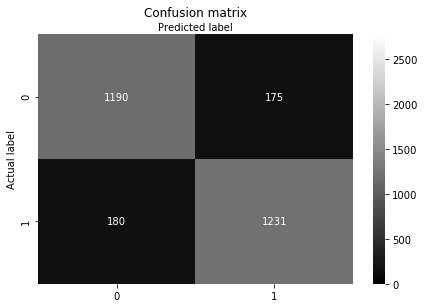

In [178]:
class_names=[1,2,3]
fig, ax = plt.subplots()
from sklearn.metrics import confusion_matrix
import sklearn.metrics as metrics

cm = confusion_matrix(y_test, y_pred)

class_names=['SL', 'nSL']

tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cm), annot=True, cmap="gray" ,fmt='g',vmin=0,vmax=len(y_test))
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')


Precision ($P$) is defined as the number of true positives ($T_p$) over the number of true positives plus the number of false positives($F_p$).

$P=\frac{T_p}{T_p+F_p}$

Recall ($R$) is defined as the number of true positives ($T_p$) over the number of true positives plus the number of false negatives($F_n$).

$R=\frac{T_p}{T_p+F_n}$

In [120]:
# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred))

Precision: 0.8755334281650071
Recall: 0.8724309000708718


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.95')

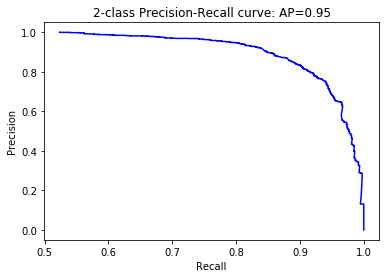

In [121]:
precision, recall, thresholds = metrics.precision_recall_curve(y_test, scores)
average_precision = metrics.average_precision_score(y_test, scores)
plt.plot(precision,recall,color='blue')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [176]:
from sklearn.metrics import confusion_matrix, classification_report


print(classification_report(y_test, y_pred))

precision    recall  f1-score   support

         0.0       0.87      0.87      0.87      1365
         1.0       0.88      0.87      0.87      1411

    accuracy                           0.87      2776
   macro avg       0.87      0.87      0.87      2776
weighted avg       0.87      0.87      0.87      2776



## Feature importance

First of all, I assume that you call features the variables and not the samples/observations. In this case, you could do something like the following by creating a biplot function that shows everything in one plot. In this example I am using the iris data.

Before the example, please note that the basic idea when using PCA as a tool for feature selection is to select variables according to the magnitude (from largest to smallest in absolute values) of their coefficients (loadings). See my last paragraph after the plot for more details.

PART1: I explain how to check the importance of the features and how to plot a biplot.

PART2: I explain how to check the importance of the features and how to save them into a pandas dataframe using the feature names.





### Data transformation

In [125]:
from sklearn.preprocessing import StandardScaler
sc_X = StandardScaler()
X_train_sc = sc_X.fit_transform(X_train)
X_test_sc = sc_X.transform(X_test)

In [126]:
from sklearn.decomposition import PCA
pca = PCA() 
X_train_pca = pca.fit_transform(X_train_sc)
X_test_pca = pca.transform(X_test_sc)
total=sum(pca.explained_variance_)
k=0
current_variance=0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k=k+1
print(k)

840


In [127]:
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
np.random.seed(0)

# 10 samples with 5 features
#train_features = np.random.rand(10,5)
train_features=X_train
model = PCA(n_components=840).fit(train_features)
X_pc = model.transform(train_features)

# number of components
n_pcs= model.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
most_important = [np.abs(model.components_[i]).argmax() for i in range(n_pcs)]

initial_feature_names = X.columns
# get the names
most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): most_important_names[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())

In [143]:
df

0     1
0      PC0    25
1      PC1   777
2      PC2   133
3      PC3   106
4      PC4   198
..     ...   ...
835  PC835   895
836  PC836  1697
837  PC837  2133
838  PC838   478
839  PC839  2711

[840 rows x 2 columns]

In [159]:
 y=[x for x in np.arange(0,840) if x not in df.iloc[:,1].drop_duplicates()]

 print('The most important features are', len(y),'out of 840 Principal Components of the data')

The most important features are 205 out of 840 Principal Components of the data


In [171]:
data_domains[data_domains['domain-name']==x[y][1]]



name domain-name                               domain-descrip  \
314   ARF1     PF00025  Arf; Small GTPase superfamily, ARF/SAR type   
315   ARF2     PF00025  Arf; Small GTPase superfamily, ARF/SAR type   
316   ARF3     PF00025  Arf; Small GTPase superfamily, ARF/SAR type   
336   ARL1     PF00025  Arf; Small GTPase superfamily, ARF/SAR type   
337   ARL3     PF00025  Arf; Small GTPase superfamily, ARF/SAR type   
941   CIN4     PF00025  Arf; Small GTPase superfamily, ARF/SAR type   
5411  SAR1     PF00025  Arf; Small GTPase superfamily, ARF/SAR type   

      domain-start  domain-end domain-method  domain-id  
314              6         176          Pfam    2060329  
315              6         176          Pfam    2062908  
316              6         177          Pfam    2081975  
336              5         177          Pfam    2074260  
337             12         183          Pfam    2090482  
941              4         186          Pfam    2078329  
5411            11         190          Pfam    2063483